In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from energy_model import *
plt.style.use('seaborn')

In [2]:
files = glob.glob('energy_balance/**.csv')
files.sort()
files[:6]

['energy_balance/energy_balance_plant_2589.csv',
 'energy_balance/energy_balance_plant_3265.csv',
 'energy_balance/energy_balance_plant_3806.csv',
 'energy_balance/energy_balance_plant_4046.csv',
 'energy_balance/energy_balance_plant_46.csv',
 'energy_balance/energy_balance_plant_566.csv']

In [11]:
df = pd.read_csv('energy_balance/energy_balance_plant_4046.csv', parse_dates=True, index_col='date')
df.head()

,Plant ID,diversion_rate_kgM,withdrawal_rate_kgM,discharge_rate_kgM,consumption_rate_kgM,avg_intake_temp_C,max_intake_temp_C,avg_discharge_temp_C,max_discharge_temp_C,Nameplate Capacity (MW),max_withdrawal_rate_kgM,elc_mmbtu_in,elc_mwh_out,elc_in_kj,elc_out_kj,modeled_discharge_temp,R_combined,temp_limit
date,,,,,,,,,,,,,,,,,,
2016-01-31,4046.0,0.0,4.041137e+10,4.041137e+10,0.0,3.333333,6.944444,20.833333,76.0,1286.0,2.460628e+11,9375634.0,896388.0,9.892228e+12,3.226997e+12,20.489884,0.565091,31.7
2016-02-29,4046.0,0.0,3.780419e+10,3.780419e+10,0.0,3.333333,6.666667,20.555556,76.0,1286.0,2.301878e+11,8771434.0,838643.0,9.254737e+12,3.019115e+12,20.491000,0.565091,31.7
2016-03-31,4046.0,0.0,2.891457e+10,2.891457e+10,0.0,3.888889,6.666667,19.444444,74.5,1286.0,2.460628e+11,6270397.0,599512.0,6.615894e+12,2.158243e+12,19.925314,0.565091,31.7
2016-04-30,4046.0,0.0,5.675675e+10,5.675675e+10,0.0,6.388889,10.000000,15.833333,71.5,1286.0,2.381253e+11,8071884.0,771747.0,8.516642e+12,2.778289e+12,16.905797,0.565091,31.7
2016-05-31,4046.0,0.0,6.054387e+10,6.054387e+10,0.0,9.166667,12.222222,20.000000,83.5,1286.0,2.460628e+11,9364257.0,895306.0,9.880224e+12,3.223102e+12,20.604260,0.565091,31.7


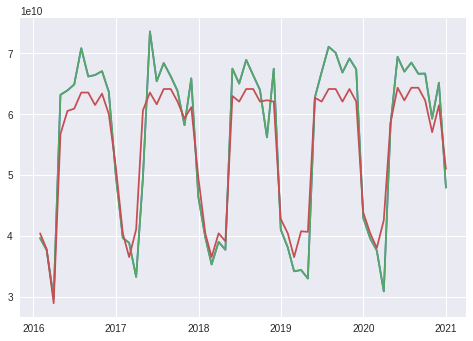

In [12]:
deltaE = df.elc_in_kj-df.elc_out_kj
deltaT = df.avg_discharge_temp_C - df.avg_intake_temp_C
waste_heat = np.ones(len(df)) - df.R_combined
cw = np.ones(len(df))*C_w
hw = np.ones(len(df))*h_w
evap = df.consumption_rate_kgM

W_in = (waste_heat*deltaE-evap*hw)/(cw*deltaT)
W_in2 = (waste_heat*deltaE)/(cw*deltaT)
plt.plot(W_in)
plt.plot(W_in2)
plt.plot(df.withdrawal_rate_kgM)

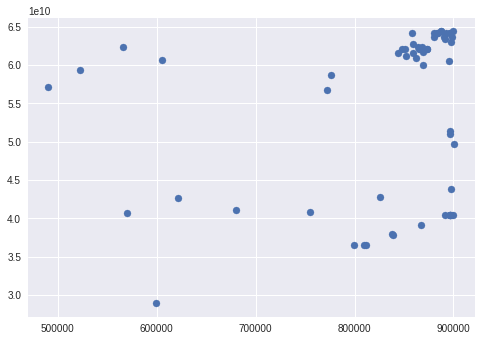

In [13]:
plt.scatter(df.elc_mwh_out, df.withdrawal_rate_kgM)

In [6]:
files

['energy_balance/energy_balance_plant_2589.csv',
 'energy_balance/energy_balance_plant_3265.csv',
 'energy_balance/energy_balance_plant_3806.csv',
 'energy_balance/energy_balance_plant_4046.csv',
 'energy_balance/energy_balance_plant_46.csv',
 'energy_balance/energy_balance_plant_566.csv',
 'energy_balance/energy_balance_plant_6000.csv',
 'energy_balance/energy_balance_plant_6011.csv',
 'energy_balance/energy_balance_plant_6014.csv',
 'energy_balance/energy_balance_plant_6038.csv',
 'energy_balance/energy_balance_plant_6045.csv',
 'energy_balance/energy_balance_plant_6099.csv',
 'energy_balance/energy_balance_plant_6110.csv',
 'energy_balance/energy_balance_plant_6115.csv',
 'energy_balance/energy_balance_plant_6168.csv',
 'energy_balance/energy_balance_plant_8036.csv',
 'energy_balance/energy_balance_plant_880.csv']

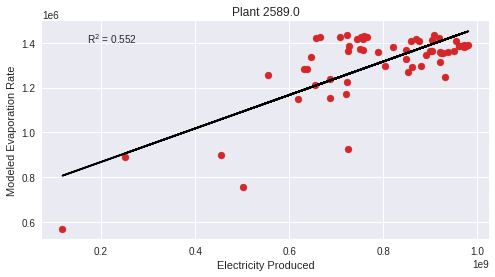

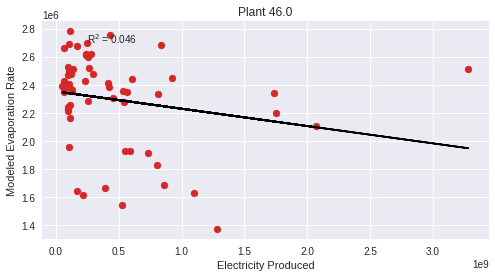

In [7]:
for f in (files[0],files[4]):
    df = pd.read_csv(f, parse_dates=True, index_col='date')
    plant_id = df['Plant ID'].values[0]
    fig,ax=plt.subplots(figsize=(8,4))
    df_i = df[['consumption_rate_kgM', 'elc_mwh_out']]
    model = linear_fit(df_i)
    y_pred=model.fittedvalues
    x_vals = df_i.iloc[:,0]
    y_true=df_i.iloc[:,1]
    r_squared = model.rsquared
    ax.scatter(x=x_vals, y=y_true, color='tab:red')
    ax.plot(x_vals, y_pred, color='k')
    ax.annotate(r'R$^2$ = {}'.format(round(r_squared,3)), xy=(.1, .9), xycoords=ax.transAxes)
    ax.set_title(f'Plant {plant_id}')
    ax.set_xlabel('Electricity Produced')
    ax.set_ylabel('Modeled Evaporation Rate')
    plt.show()

2589.0


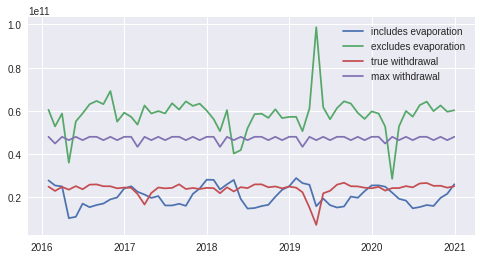

3265.0


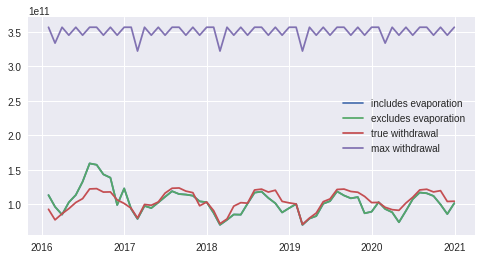

3806.0


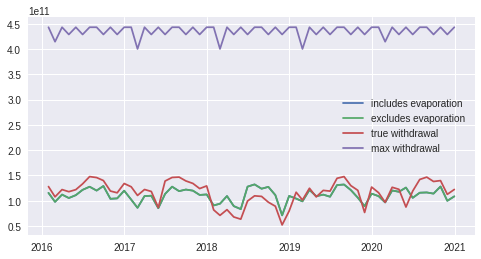

4046.0


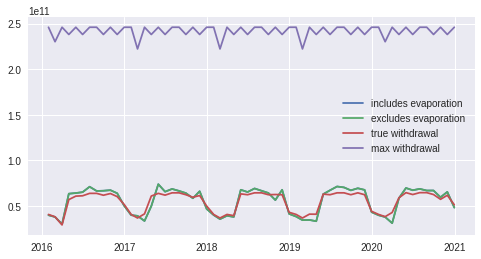

46.0


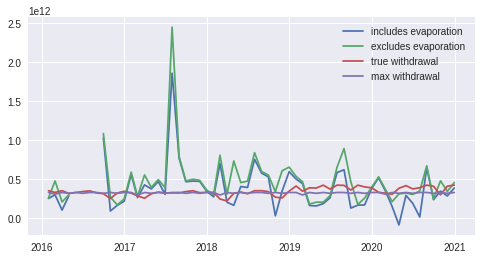

566.0


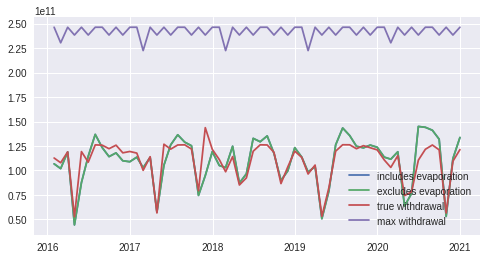

6000.0


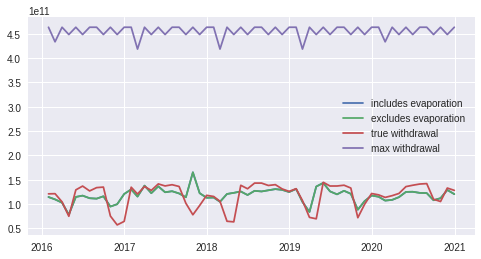

6011.0


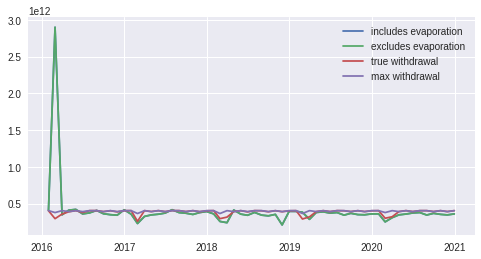

6014.0


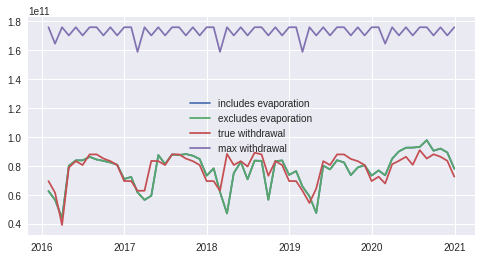

6038.0


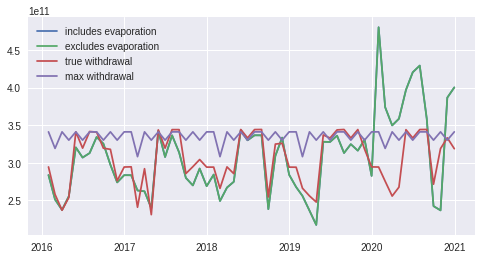

6045.0


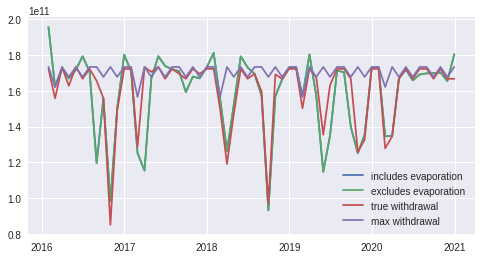

6099.0


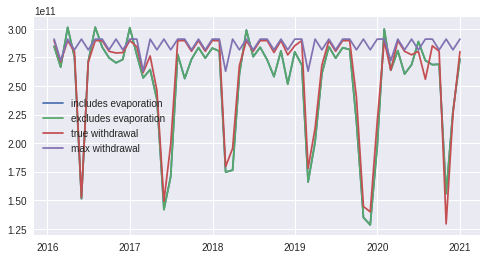

6110.0


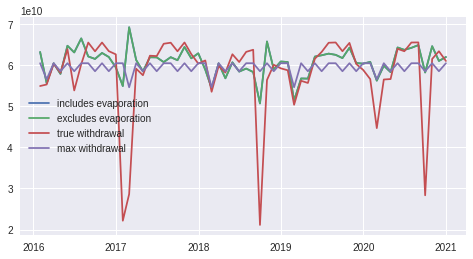

6115.0


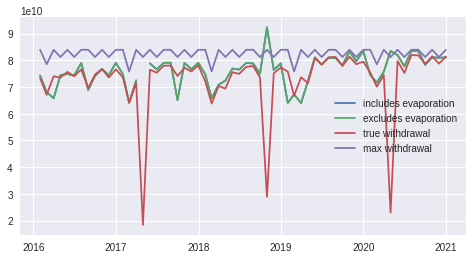

6168.0


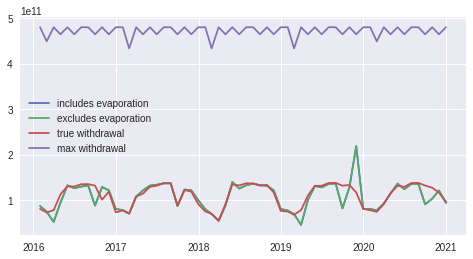

8036.0


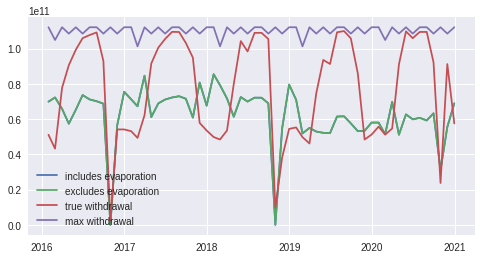

880.0


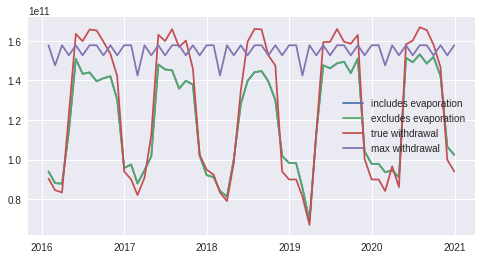

In [10]:
for f in files:
    df = pd.read_csv(f, parse_dates=True, index_col='date')
    plant_id = df['Plant ID'].values[0]
    print(plant_id)
    fig,ax=plt.subplots(figsize=(8,4))
    deltaE = df.elc_in_kj-df.elc_out_kj
    deltaT = df.avg_discharge_temp_C - df.avg_intake_temp_C
    waste_heat = np.ones(len(df)) - df.R_combined
    cw = np.ones(len(df))*C_w
    hw = np.ones(len(df))*h_w
    evap = df.consumption_rate_kgM

    W_in = (waste_heat*deltaE-evap*hw)/(cw*deltaT)
    W_in2 = (waste_heat*deltaE)/(cw*deltaT)
    plt.plot(W_in, label='includes evaporation')
    plt.plot(W_in2, label='excludes evaporation')
    plt.plot(df.withdrawal_rate_kgM, label='true withdrawal')
    plt.plot(df.max_withdrawal_rate_kgM, label='max withdrawal')
    plt.legend()
    plt.show()